Import libraries

In [64]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [65]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [66]:
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0
print(cuda.get_device_name(cuda.current_device()))

NVIDIA GeForce RTX 2080 Ti


In [67]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
NVIDIA GeForce RTX 2080 Ti


Processing(데이터 전처리)

In [68]:
mypath = os.getcwd() + '/dataset/'
# get current word directory
IMAGE_PATH = mypath + 'original_images/'
# original rgb image가 있는 directory의 절대 경로
DEPTH_PATH = mypath + 'depth/'
MASK_PATH = mypath + 'mask/'
# label image가 있는 directory의 절대 경로

n_classes = 2

def create_df():
    name = []
    # 비어있는 리스트 'name'를 생성함

    '''
    image_path의 모든 하위 폴더들에 대해서 for 문이 실행됨
    dirname: 그 폴더의 path
    _: dirname 바로 밑에 있는 폴더 리스트
    filenames: dirname 바로 밑에 있는 파일 리스트
    '''
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
            # .split('.'): 'filename' 문자열을 마침표(점)를 기준으로 하여 여러 하위 문자열의 목록으로 분할함
            # [0]: 결과적으로 생성된 하위 문자열 목록에서 첫 번째 요소(인덱스 0)을 선택하여 파일 이름의 기본 이름을 추출함
            '''
            filename = "example.txt
            base_name = filename.split('.')[0]
            print(base_name)
            -> example '''
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
df

# print('total images: ', len(df))
    # total images: 50

# print(len(df['id'].values))
    # 50

# print(df['id'].values)
    # ['22' '27' '30' '19' '42' '7' '16' '11' '12' '5' '50' '31' '36' '25' '46'
    #  '18' '17' '2' '13' '33' '15' '45' '24' '47' '8' '9' '35' '10' '20' '3'
    #  '41' '6' '21' '43' '14' '44' '28' '38' '29' '40' '23' '34' '39' '37' '32'
    #  '49' '4' '48' '1' '26']

,id
0,22
1,27
2,30
3,19
4,42
5,7
6,16
7,11
8,12
9,5


In [69]:
# 만든 데이터 프레임을 train, validation, test dataset으로 나누기
# split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.2, random_state=19)
# 50개 중 10개가 test dataset으로 분류됨
X_train, X_val = train_test_split(X_trainval, test_size=0.25, random_state=19)
# 40개 중 10개가 validation dataset으로 분류됨

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

print(X_train[1])
print(type(X_train[1]))

Train Size   :  30
Val Size     :  10
Test Size    :  10
4
<class 'str'>


Image Size (720, 1280, 4)
Mask Size (720, 1280)


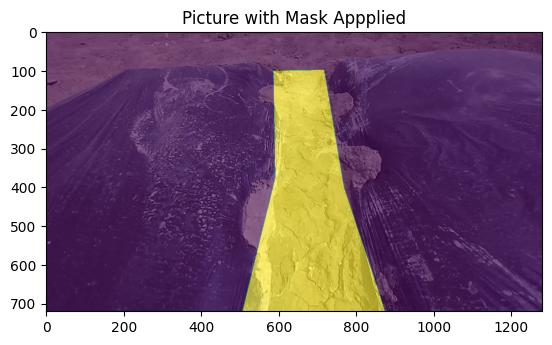

In [70]:
# 시험삼아 이미지 하나를 띄워보자
img = Image.open(IMAGE_PATH + df['id'][30] + '.png')
mask = Image.open(MASK_PATH + df['id'][30] + '.png')

print('Image Size', np.asarray(img).shape)
# PIL 이미지를 numpy 배열로 변환하고, 그것의 크기를 출력함
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
# alpha: 마스크의 불투명도
# alpha 값이 1이면 원본 이미지는 보이지 않고 마스크만 보임
plt.title('Picture with Mask Appplied')
# 제목
plt.show()

Custom Dataset(이것도 전처리 과정 중 하나)

In [71]:
# class Normalize4Channels(object):
#     def __init__(self, mean, std):
#         self.mean = torch.Tensor(mean)
#         self.std = torch.Tensor(std)

#     def __call__(self, tensor):
#         # R, G, B 채널에 대한 정규화
#         tensor[:4] = (tensor[:4] - self.mean[:4]) / self.std[:4]

#         return tensor

class DroneDataset(Dataset):
    
    def __init__(self, img_path, depth_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.depth_path = depth_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        depth = cv2.imread(self.depth_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        depth = np.expand_dims(depth, axis=2)
        img = np.concatenate((img, depth), axis=2)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        # t = T.Compose([T.ToTensor(), Normalize4Channels(self.mean, self.std)])
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        # 이미지 변환 파이프라인을 정의함
        img = t(img)
        # 이미지를 텐서로 변환하고, 평균과 표준편차를 사용하여 정규화함
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3, -1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [72]:
img = cv2.imread(IMAGE_PATH + df['id'][30] + '.png') # open cv로 이미지 불러오기
print(img.shape)
depth = cv2.imread(DEPTH_PATH + df['id'][30] + '.png', cv2.IMREAD_GRAYSCALE) # open cv로 뎁스 이미지 불러오기(gray scale 2차원)
print(depth.shape)
depth = np.expand_dims(depth, axis=2) # 뎁스이미지 1채널로
print(depth.shape)
mask = cv2.imread(MASK_PATH + df['id'][30] + '.png', cv2.IMREAD_GRAYSCALE) 

img = np.concatenate((img, depth), axis=2) # 3채널 이미지랑 1채널 뎁스랑 합쳐서 4채널 만들기
print(img.shape)

# print(type(IMAGE_PATH))
# print(type(df['id'][30]))

(720, 1280, 3)
(720, 1280)
(720, 1280, 1)
(720, 1280, 4)


In [73]:
mean=[0.485, 0.456, 0.406, 0.485]
std=[0.229, 0.224, 0.225, 0.229]
# mean=[0.485, 0.456, 0.406]
# std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

# datasets
train_set = DroneDataset(IMAGE_PATH, DEPTH_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, DEPTH_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

Model 만들기(Unet)

In [74]:
#%pip install git+https://github.com/qubvel/segmentation_models.pytorch

model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', in_channels=4, classes=2, activation="softmax")

Training

In [75]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [76]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        # training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            # training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device)
            # forward
            output = model(image)
            loss = criterion(output, mask)
            # evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            # backward
            loss.backward()
            optimizer.step() # update weight
            optimizer.zero_grad() # reset gradient
            
            # step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            # validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    # reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device)
                    output = model(image)
                    # evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    # loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            # calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            # iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [77]:
max_lr = 1e-3
epoch = 5
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/nari/anaconda3/envs/nari/lib/python3.11/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.548 
Epoch:1/5.. Train Loss: 0.518.. Val Loss: 0.548.. Train mIoU:0.596.. Val mIoU: 0.549.. Train Acc:0.850.. Val Acc:0.785.. Time: 0.09m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 0.548 >> 0.410 
Epoch:2/5.. Train Loss: 0.384.. Val Loss: 0.410.. Train mIoU:0.864.. Val mIoU: 0.740.. Train Acc:0.963.. Val Acc:0.905.. Time: 0.09m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 0.410 >> 0.390 
Epoch:3/5.. Train Loss: 0.360.. Val Loss: 0.390.. Train mIoU:0.863.. Val mIoU: 0.786.. Train Acc:0.963.. Val Acc:0.927.. Time: 0.09m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 0.390 >> 0.354 
saving model...
Epoch:4/5.. Train Loss: 0.349.. Val Loss: 0.354.. Train mIoU:0.888.. Val mIoU: 0.874.. Train Acc:0.970.. Val Acc:0.965.. Time: 0.09m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 0.354 >> 0.347 
Epoch:5/5.. Train Loss: 0.347.. Val Loss: 0.347.. Train mIoU:0.888.. Val mIoU: 0.890.. Train Acc:0.971.. Val Acc:0.971.. Time: 0.09m
Total time: 0.46 m


In [78]:
torch.save(model, 'Unet-Mobilenet.pt')

In [79]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

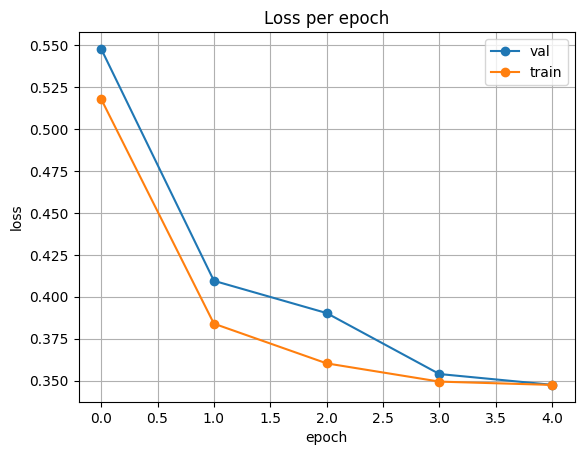

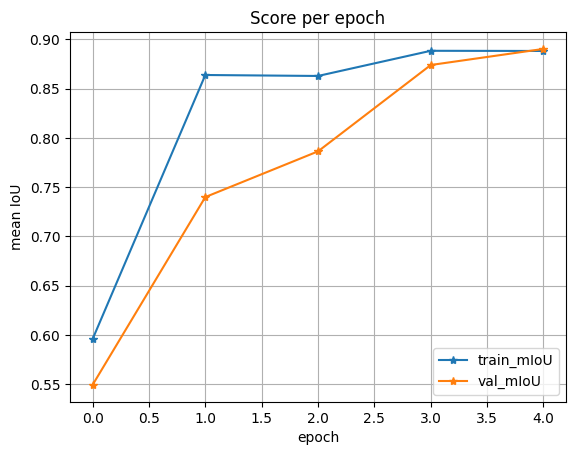

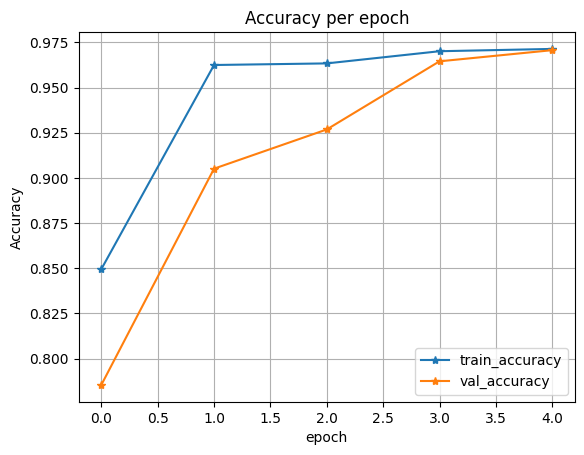

In [80]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [82]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, depth_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.depth_path = depth_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        depth = cv2.imread(self.depth_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        depth = np.expand_dims(depth, axis=2)
        img = np.concatenate((img, depth), axis=2)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, DEPTH_PATH, MASK_PATH, X_test, transform=t_test)

In [83]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406, 0.485], std=[0.229, 0.224, 0.225, 0.229]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [84]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406, 0.485], std=[0.229, 0.224, 0.225, 0.229]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [85]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

/home/nari/anaconda3/envs/nari/lib/python3.11/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


In [86]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [87]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/10 [00:00<?, ?it/s]

In [88]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [89]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/10 [00:00<?, ?it/s]

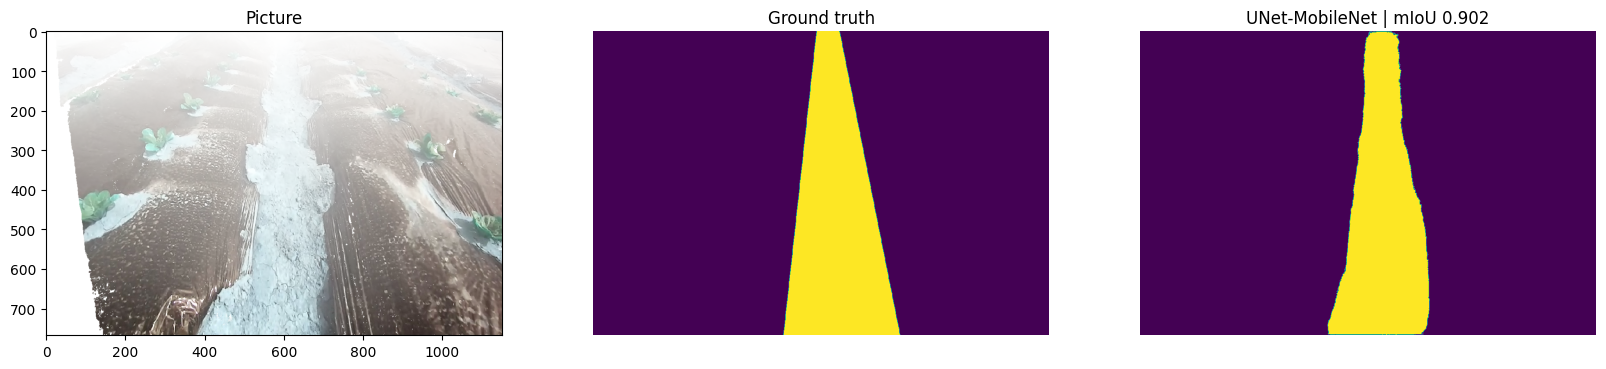

In [90]:
image2, mask2 = test_set[5]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

In [91]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.8936107147469421


In [92]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.9725623236762153
